# Wrangling and cleansing business data

**Approach and pitfalls of data pre-processing based on a real-world recreated retail industry example**

*Dennis Gluesenkamp*

### Table of contents
* [Introduction](#introduction)
* [Objectives](#objectives)
* [Libraries and settings](#librariessettings)
* [Data allocation and preparation](#allocationpreparation)
* [Correlations between features](#correlationsfeatures)
* [Linear regression of hours ratio vs. sales units](#linearregression)
* [Predictive model](#predictivemodel)

### Introduction<a class="anchor" id="introduction"></a>

Raw data of real analytical use cases in a number of industries and companies is frequently provided in an Excel-based form. These files usually cannot be processed directly in machine learning models, but must first be cleaned and preprocessed. In this procedure, many different types of pitfalls may occur. This makes data preprocessing an essential time factor in the daily work of a data scientist.

In this concise project an Excel spreadsheet will be presented which in this form is closely oriented to a real case but contains only simulated figures for reasons of data and business results protection. The form and structure of the file correspond to a real case and could be encountered by a data scientist in a company in this way. Such a file can be the result of a download from a financial controlling system, e.g. SAP.

The data includes information about sold goods resp. product units, the associated turnover and hours worked. This information is grouped by month, store and department of the retailer. Moreover, information about the sales area in a specific department as well as about the opening hours of the store is provided.

### Objectives<a class="anchor" id="objectives"></a>

The following goals of data cleansing are addressed in this notebook:
* Import an Excel-file
* Inspect the dataset
* Check data types and do meaningful modifications
* Handle missings/data gaps
* Find and solve data inconsistencies
* Rename columns for improved usage
* Join tables to a single one

Furthermore, the data is investigated at a very high level for illustrative purposes. Here, correlations between different features are examined and a simple regression model is finally created.

### Libraries and settings<a class="anchor" id="librariessettings"></a>
The first step consists of loading the necessary libraries. In addition, a few settings are made for this notebook.

In [1]:
# Array operations and useful analysis functionalities
import numpy as np
import pandas as pd

# Seaborn library for visualizations in the notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
%matplotlib inline

# Interactive widgets for user-selection
# This functionality can't be executed in every notebook viewer!
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Scikit-learn for model building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Data allocation and preparation<a class="anchor" id="allocationpreparation"></a>
The Excel file "salesworkload.xlsx" is read with pandas. The two sheets are loaded to different DataFrames. The first sheet contains the information concerning the sold goods supplemented by store and working hours. The other sheet covers detailed information about the opening hours in a specific market, which depends on opening scheme model and the location of the store due to different holiday schedules.

After completion of the pre-processing, we would like to have a unified, cleansed data set available with which we can continue to work. In order to avoid seasonal effects, we also use a cumulative view over the months. This is reasonable and requested for a first analysis and to maintain a certain degree of simplicity from a business point of view.

#### Loading the data

In [2]:
df_goods = pd.read_excel('dat/salesworkload.xlsx',        # file name
                         sheet_name = 0,                  # index of sheet in file
                         header = 1,                      # row index of column names
                         na_values = ['#NV', 'Err:520'])  # special treatment of missing-/error-values
df_hours = pd.read_excel('dat/salesworkload.xlsx',
                         sheet_name = 1,
                         header = 5,
                         na_values = ['#NV', 'Err:520'])

In this case, it has already been clarified through advance communication with the business unit that there is missing information in the data. For this reason, the values "#NV" and "Err:520" could already be intercepted here. Collecting as much information as possible about the data before the analysis saves time during the later processing.

#### Handling implausible data types

However, the data types of the individual columns should still be checked.

In [3]:
print("Goods:")
print(df_goods.dtypes)
print(" ")
print("Hours:")
print(df_hours.dtypes)

Goods:
MonthYear         object
Time index       float64
Country           object
StoreID          float64
City              object
Dept_ID          float64
Dept. Name        object
HoursOwn          object
HoursLease       float64
Sales units      float64
Turnover         float64
Customer         float64
Area (m2)        float64
Opening hours     object
dtype: object
 
Hours:
id               int64
Store name      object
Region          object
Scheme          object
10               int64
11               int64
12               int64
1                int64
2                int64
3                int64
4                int64
5                int64
6                int64
7                int64
8                int64
9                int64
Unnamed: 16    float64
10.1             int64
11.1             int64
12.1             int64
1.1              int64
2.1              int64
3.1              int64
4.1              int64
5.1              int64
6.1              int64
7.1              int64

Most of the column types have been recognized correctly. The IDs must be converted to a categorical feature without a decimal point. This is done later after the cleansing.

The column "HoursOwn" stands out, because the type is specified here as *object*. However, one would expect a numeric type. For this reason we search for non-numeric records in the column "HoursOwn", which is otherwise obviously populated with numbers.

In [4]:
goods_notnum = df_goods[['HoursOwn']].applymap(np.isreal).values
df_goods[~goods_notnum][['Dept_ID', 'HoursOwn']]

,Dept_ID,HoursOwn
2966,6.0,?
5889,2.0,?


In this way we were able to identify that a question mark ("?") is placed in two cells of the column "HoursOwn", for whatsoever reason. Experience from business has shown that in manually processed Excel files errors - similar to this example - can occur quite easily.

#### Replacement

We don't want to ignore these question marks or even delete the cells. Rather, we would like to make a meaningful replacement/imputation here and insert the respective mean value of the department for "HoursOwn". Afterwards, the type of the column is changed to numeric.

In [5]:
# Calculate the mean of HoursOwn for the specified department and without the cells containing a question mark
imp_dept6 = df_goods.loc[(df_goods['Dept_ID'] == 6.0) & (df_goods['HoursOwn'] != '?')]['HoursOwn'].mean()
imp_dept2 = df_goods.loc[(df_goods['Dept_ID'] == 2.0) & (df_goods['HoursOwn'] != '?')]['HoursOwn'].mean()

# Replace the question marks
df_goods.loc[(df_goods['Dept_ID'] == 6.0) & (df_goods['HoursOwn'] == '?'), ['HoursOwn']] = imp_dept6
df_goods.loc[(df_goods['Dept_ID'] == 2.0) & (df_goods['HoursOwn'] == '?'), ['HoursOwn']] = imp_dept2

# Give an information about the new values
print('Department 6: ' + str(imp_dept6))
print('Department 2: ' + str(imp_dept2))

Department 6: 10018.232692650332
Department 2: 2425.853385300666


In [6]:
df_goods['HoursOwn'] = pd.to_numeric(df_goods['HoursOwn'])   # convert column now to numeric
df_goods.dtypes                                              # check type of column

MonthYear         object
Time index       float64
Country           object
StoreID          float64
City              object
Dept_ID          float64
Dept. Name        object
HoursOwn         float64
HoursLease       float64
Sales units      float64
Turnover         float64
Customer         float64
Area (m2)        float64
Opening hours     object
dtype: object

#### Missings

In order to obtain a general overview of the values stored in the data set, some statistical values are retrieved in an overview.

In [7]:
df_goods.describe(include = 'all')

,MonthYear,Time index,Country,StoreID,City,Dept_ID,Dept. Name,HoursOwn,HoursLease,Sales units,Turnover,Customer,Area (m2),Opening hours
count,7658,7650.000000,7650,7650.000000,7650,7650.000000,7650,7650.000000,7650.000000,7.650000e+03,7.650000e+03,0.0,6800.000000,7650
unique,10,NaN,11,NaN,50,NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,3
top,11.2016,NaN,United Kingdom,NaN,Warsaw (II),NaN,Non Food,NaN,NaN,NaN,NaN,NaN,NaN,Type A
freq,850,NaN,918,NaN,153,NaN,450,NaN,NaN,NaN,NaN,NaN,NaN,5661
mean,NaN,5.000000,NaN,61995.220000,NaN,9.470588,NaN,7721.348494,22.036078,1.076471e+06,3.721393e+06,NaN,7557.276935,NaN
std,NaN,2.582158,NaN,29924.581631,NaN,5.337429,NaN,12320.707956,133.299513,1.728113e+06,6.003380e+06,NaN,10727.610965,NaN
min,NaN,1.000000,NaN,12227.000000,NaN,1.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,0.000000,NaN
25%,NaN,3.000000,NaN,29650.000000,NaN,5.000000,NaN,1951.926750,0.000000,5.457125e+04,2.726798e+05,NaN,563.160000,NaN
50%,NaN,5.000000,NaN,75400.500000,NaN,9.000000,NaN,3508.905000,0.000000,2.932300e+05,9.319575e+05,NaN,1212.960000,NaN
75%,NaN,7.000000,NaN,87703.000000,NaN,14.000000,NaN,7430.067000,0.000000,9.175075e+05,3.264432e+06,NaN,11199.360000,NaN


Here, it is noticeable that:
* in column "MonthYear" there are eight records more than time indices  
* only 6,800 values are stored for the "Area (m2)" feature 
* the column "Customer" doesn't include anything

To begin, let's take the second point and look for the rows where "Area (m2)" has no value, i.e. *NaN*.

In [8]:
df_goods[df_goods['Area (m2)'].isnull()]

,MonthYear,Time index,Country,StoreID,City,Dept_ID,Dept. Name,HoursOwn,HoursLease,Sales units,Turnover,Customer,Area (m2),Opening hours
850,- - - -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1701,- - - -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2552,- - - -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3403,- - - -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4254,- - - -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,06.2017,9.0,Sweden,29650.0,Gothenburg,12.0,Checkout,6322.323,0.0,3886530.0,14538825.0,NaN,NaN,Type A
7654,06.2017,9.0,Sweden,29650.0,Gothenburg,16.0,Customer Services,4270.479,0.0,245.0,0.0,NaN,NaN,Type A
7655,06.2017,9.0,Sweden,29650.0,Gothenburg,11.0,Delivery,0.000,0.0,0.0,0.0,NaN,NaN,Type A
7656,06.2017,9.0,Sweden,29650.0,Gothenburg,17.0,others,2224.929,0.0,245.0,0.0,NaN,NaN,Type A


We see two things now:
* there are in total eight rows in which "MonthYear" consists of four dashes, but all columns do not have any value 
* the month of June 2017 does not contain any information about the sales area

Thus, we have already discovered the answers for the first two issues mentioned above. The eight additional lines (MonthYear vs. Time index) are like visual separations between the months and contain no relevant data. In addition, in order to remain consistent, we can only perform an analysis until May 2017 because the area is not available in its entirety after this month. If we were to look at different months in terms of quantity of goods and sales area, we would not be able to guarantee the correctness of the derived conclusions. True, using the values of May for a cumulative consideration can also be questioned. The ranges can vary in size over the months. Nevertheless, we stick to this simplification because it is the latest version available.

In [9]:
df_goods = df_goods[df_goods['Area (m2)'].notnull()]   # drop all above shown rows with no/incomplete content
df_goods = df_goods.drop(['Customer'], axis = 1)       # drop "Customer" column, due to no values

#### Cumulation of monthly figures

In the following, we sum up from the beginning of the data series to May 2017. It is important to keep the information about the respective market and department, as this is the elementary unit of consideration.

First, we are extracting the departmental sales areas as of May 2017. To avoid a "SettingWithCopyWarning" while generating a new identifier for store and department combined, a detour via a buffer is necessary (see https://bit.ly/2LdPdjo).

In [10]:
# Subset the DataFrame as of May 2017
df_area_buffer = df_goods[df_goods['MonthYear'] == '05.2017']
# Extracting row indices of the subset
buffer_row_indices = df_goods[df_goods['MonthYear'] == '05.2017'].index

# Creating new DataFrame based on the indices
df_area = df_goods.loc[buffer_row_indices, :]

# Adding new column with identifier for store and department
df_area['ID'] = df_area['StoreID'].map(str) + df_area['Dept_ID'].map(str)
df_area = df_area[['ID', 'Area (m2)']]

Now the months are cumulated and a new DataFrame is created.

In [11]:
df_goods['ID'] = df_goods['StoreID'].map(str) + df_goods['Dept_ID'].map(str)

df_cum = df_goods[['ID',
                   'HoursOwn',
                   'Sales units',
                   'Turnover']].groupby(['ID'], as_index = False).sum()

df_cum = pd.merge(df_cum, df_area,
                  on = 'ID',
                  how = 'left')

df_cum = pd.merge(df_cum, df_goods[['ID', 'StoreID', 'Dept_ID', 'Dept. Name']],
                  on = 'ID',
                  how = 'left').drop_duplicates()

Because we had already seen in the table with sold goods that we only want to look through to May. So, for the second table with the opening hours, we can remove all the other columns except the one representing the cumulative figures until May 2017 which is the column "5.1". Beside this the ID is of interest only.

In [12]:
df_hours = df_hours.drop(df_hours.columns[1:24], axis = 1)
df_hours = df_hours.drop(df_hours.columns[2:9], axis = 1)

#### Column names
The current column names are not ideal for further data processing. Above all, you want to prevent later problems with character encoding or inconsistent names. The columns are therefore renamed.

In [13]:
df_cum = df_cum.rename(columns = {'Dept_ID': 'DeptID',
                                  'Dept. Name': 'DeptName',
                                  'Sales units': 'SalesUnits',
                                  'Area (m2)': 'Area'})

In [14]:
df_hours = df_hours.rename(columns = {'id': 'StoreID',
                                      '5.1': 'CumulativeHours'})

#### Merging and hours ratio
The two individual data sets are merged into one, so that the cumulated number of opening hours is also available in the main table and we only have to work with one flat DataFrame. In addition, we do not want to consider the absolute number of hours worked, because the total amount of hours where the store is opened differs. Rather, we are interested in the ratio of hours worked in a department to the total opening hours of the store. This reflects the effort made in a market/department even better. For this purpose, an additional column "HoursRatio" is calculated and included.

In [15]:
df = pd.merge(df_cum, df_hours, on = 'StoreID', how = 'left')    # Joining both tables
df['HoursRatio'] = df['HoursOwn'] / df['CumulativeHours']        # Create new ratio feature
df.head(3)                                                       # Check first data objects

,ID,HoursOwn,SalesUnits,Turnover,Area,StoreID,DeptID,DeptName,CumulativeHours,HoursRatio
0,12227.01.0,42402.678,5803985.0,22392618.0,1089.84,12227.0,1.0,Dry,2932,14.462032
1,12227.011.0,0.000,715.0,996.0,0.00,12227.0,11.0,Delivery,2932,0.000000
2,12227.012.0,76629.450,47398365.0,156179178.0,31589.40,12227.0,12.0,Checkout,2932,26.135556


#### Categorical IDs

Finally, the IDs are converted to categorical features.

In [16]:
df['ID'] = df['ID'].astype('category')
df['StoreID'] = df['StoreID'].astype('int').astype('category')
df['DeptID'] = df['DeptID'].astype('int').astype('category')

### Correlations between features<a class="anchor" id="correlationsfeatures"></a>

The relationships between the variables will now be examined in more detail. Since individual departments also have to be managed completely differently and therefore have their own underlying mechanisms, the following considerations are divided according to departments. The following departments exist in the data set.

In [17]:
df.loc[:, ['DeptID', 'DeptName']].drop_duplicates().sort_values(by = ['DeptID'])

,DeptID,DeptName
0,1,Dry
9,2,Frozen
10,3,other
11,4,Fish
12,5,Fruits & Vegetables
13,6,Meat
14,7,Clothing
15,8,Household
16,9,Hardware
1,11,Delivery


#### Removal of redundant or implausible departments

First it must be determined whether it is possible to work with all features in a meaningful way. For this we consider the distributions in the numerical variables across the departments.

##### Feature "HoursRatio"

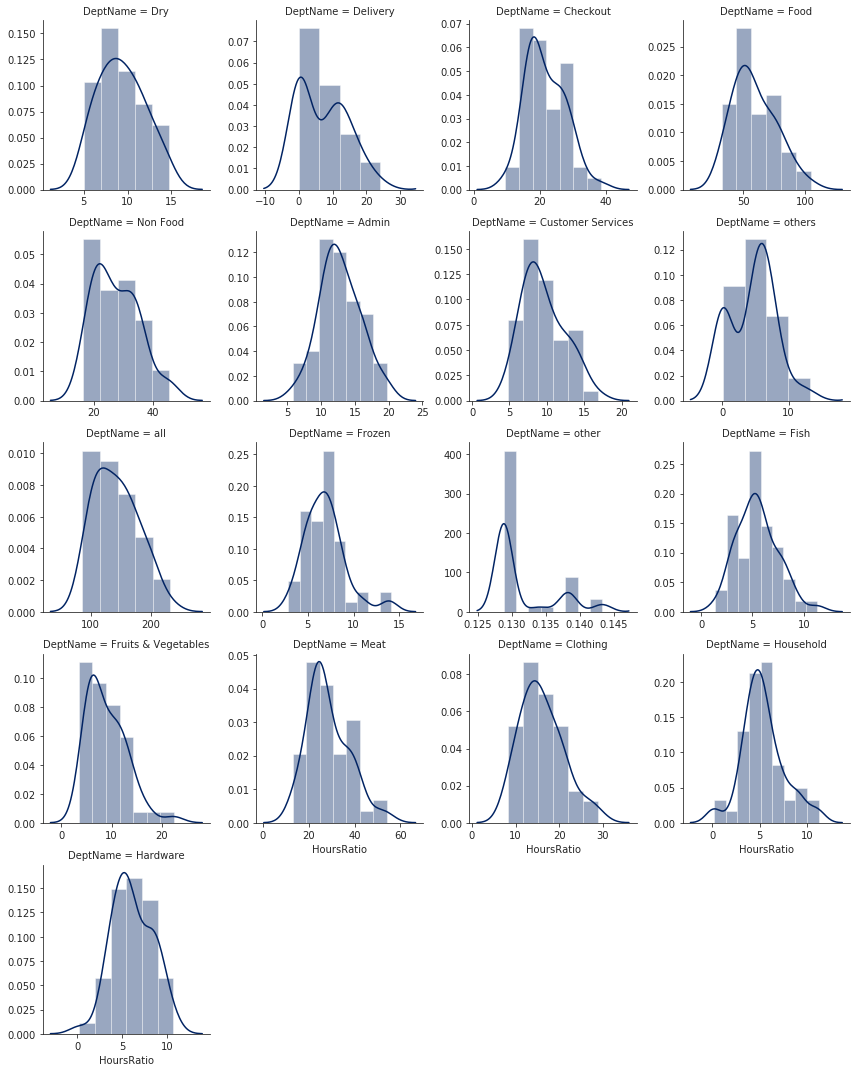

In [18]:
g_hoursratio = sns.FacetGrid(df,
                             col = 'DeptName',
                             col_wrap = 4,
                             sharex = False, sharey = False);
g_hoursratio.map(sns.distplot, 'HoursRatio', color = '#012363');

Department 3, which is *Other*, shows a very narrow distribution (see x-axis). After a view into the data set it becomes clear why: The recorded hours are all over the same. Only the cumulative hours as divisor provide the small variance in the feature "HoursRatio". This case must be passed back to the business, since it is highly doubtful that the values for department 3 are correct. Therefore, it cannot be considered in the further analysis also.

In [19]:
df['DeptID'] = df['DeptID'].cat.remove_categories([3])
df.dropna(inplace = True)

##### Feature "SalesUnits"

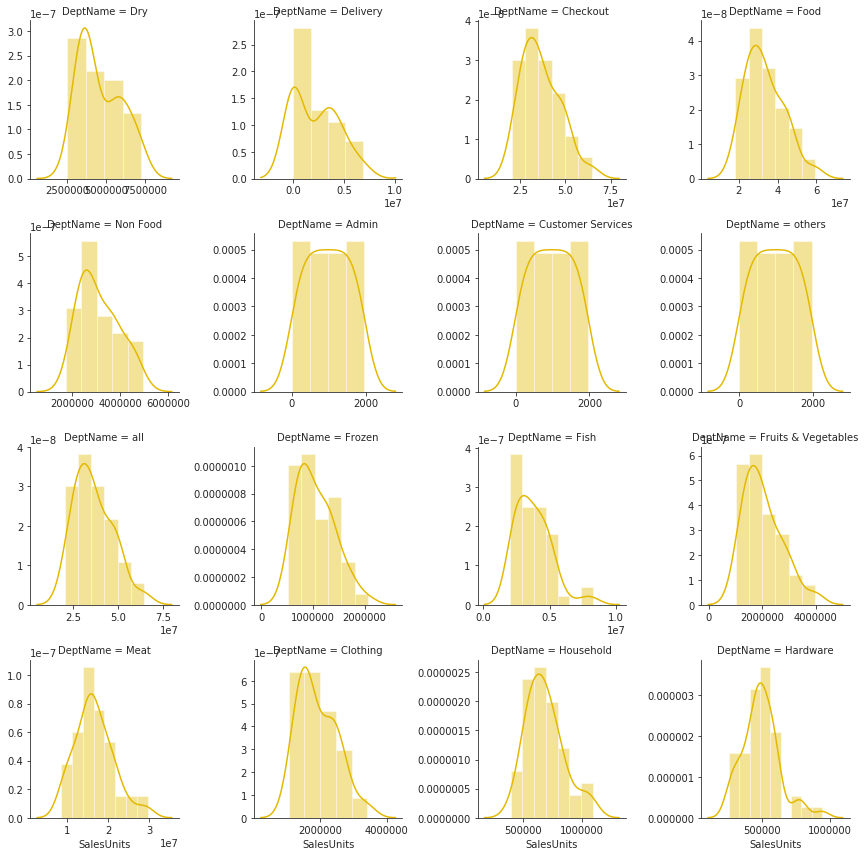

In [20]:
g_salesunits = sns.FacetGrid(df,
                             col = 'DeptName',
                             col_wrap = 4,
                             sharex = False, sharey = False);
g_salesunits.map(sns.distplot, 'SalesUnits', color = '#e3b900');

Departments 15 (*Admin*), 16 (*Customer Services*) and 17 (*Others*) are not part of the original sales areas. For this reason, their distribution in goods sold  - which is quite the same - is not very meaningful. They are therefore removed from the data set.

Department 12 is the *Checkout*, which plays a special role just like department 18, *All*. Here, all units are summed up, which is very similar to the *Food* department 13 - sum of all departments dealing with food items - due to the highest sales figures by far. In the following, therefore, only department 13 will be considered and 12 and 18 removed.

In [21]:
df['DeptID'] = df['DeptID'].cat.remove_categories([12, 15, 16, 17, 18])
df.dropna(inplace = True)

##### Feature "Turnover"

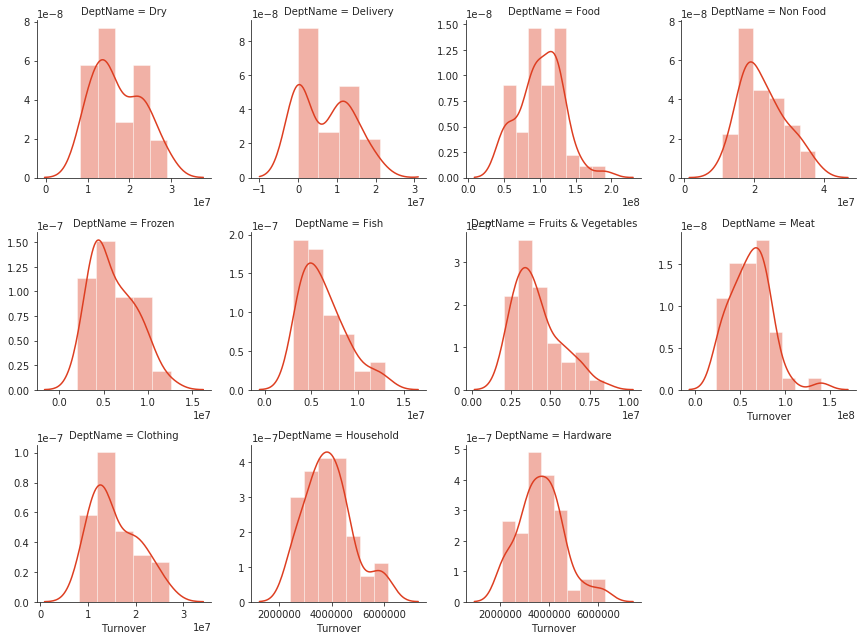

In [22]:
g_turnover = sns.FacetGrid(df,
                  col = 'DeptName',
                  col_wrap = 4,
                  sharex = False, sharey = False);
g_turnover.map(sns.distplot, 'Turnover', color = '#dd3e21');

There are no noticeable anomalies with regard to turnover.

##### Feature "Area"

In [23]:
%%capture
np.seterr(divide = 'ignore', invalid = 'ignore')
# The following FacetGrid throws an error (numpy: Invalid value
# encountered in true_divide), which has no effect. According to
# https://github.com/belltailjp/selective_search_py/issues/20
# the error is suppressed by this numpy command.

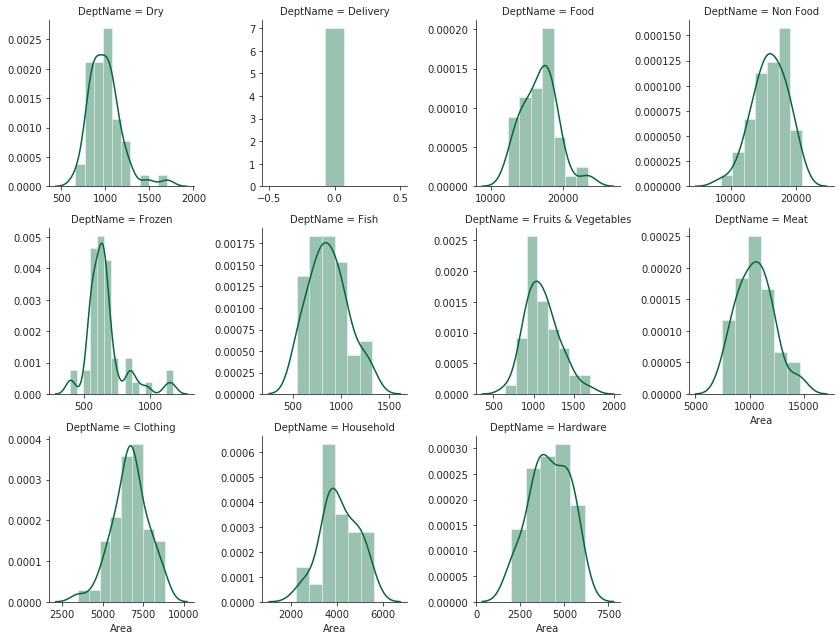

In [24]:
g_area = sns.FacetGrid(df,
                       col = 'DeptName',
                       col_wrap = 4,
                       sharex = False, sharey = False);
g_area.map(sns.distplot, 'Area', color = '#01673b');

Department 11 is *Delivery*. This makes it comprehensible that no sales area is required here and that the distribution is therefore centered on 0. The department is finally removed from the data set.

In [25]:
df['DeptID'] = df['DeptID'].cat.remove_categories([11])
df.dropna(inplace = True)

# Get a sorted list of department IDs in scope for later use
final_dept_list = np.sort(df.loc[:, ['DeptName']]
                          .drop_duplicates()
                          .to_numpy()
                          .ravel())

#### Pairwise relationship

The next step is to look at the mutual relationships between the numerical features grouped by department.

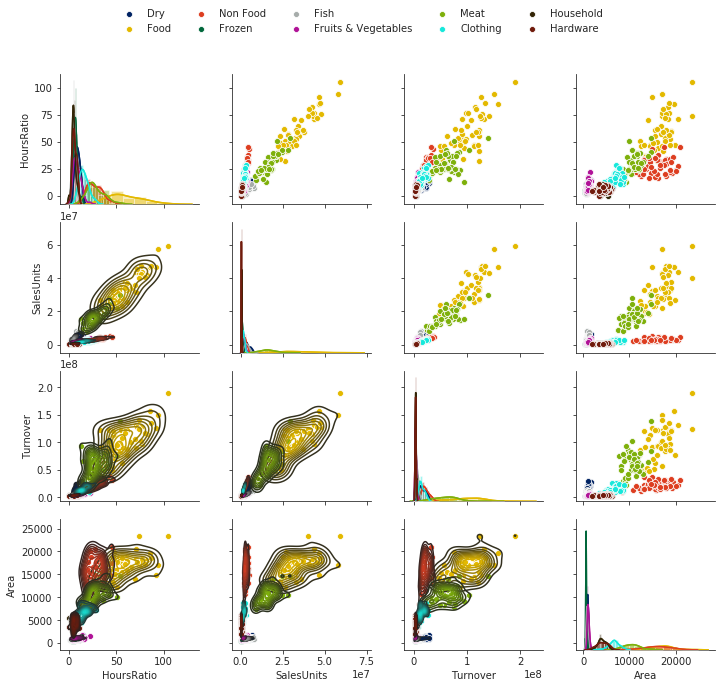

In [26]:
cpal = ['#012363', '#e3b900', '#dd3e21', '#01673b', '#a6acaa', '#b01297', '#7EB00B', '#17E8DB', '#332506', '#701B0C']
pp = sns.pairplot(df,
                  hue = 'DeptName',
                  vars = ['HoursRatio',
                          'SalesUnits',
                          'Turnover',
                          'Area'],
                  palette = cpal)
pp.map_upper(sns.scatterplot)
pp.map_lower(sns.kdeplot)
pp.map_diag(sns.distplot)
pp._legend.remove()
handles = pp._legend_data.values()
labels = pp._legend_data.keys()
pp.fig.legend(handles = handles, labels = labels, loc = 'upper center', ncol = 5, frameon = False)
pp.fig.subplots_adjust(top = 0.9, bottom = 0.1)
pp.savefig('out/pairplot.png')
pp.savefig('docs/img/pairplot.png')

In this pairplot different findings can be seen:
* Especially the distributions of sales units and turnover are dominated by a few departments with very small quantities.
* The departments appear as (sometimes) overlapping but clearly defined clusters or areas in the relationships between the individual features.
* The relationship between sales units and hours ratio (second column, first row) has clusters of departments that are somewhat ellipsoidal, i.e. linear. This suggests a further investigation using linear regression.

#### Distribution of correlation coefficients

At this point, we would like to take a look at the correlation coefficients between the numerical attributes, excluding turnover because of its proximity to sales units.

The pivot function transposes the department ID information to the columns and fills the cells with the different dimensions HoursRatio, SalesUnits, and Area.

The correlation can be calculated with pandas-internal function "corrwith". This is done three times to end up with all possible combinations. Finally, the vectors with the coefficients are concatenated in order to get a single resulting dataframe.

In [27]:
df_hours = df.loc[:, ['StoreID', 'DeptID', 'HoursRatio']]
df_hours = df_hours.pivot(index = 'StoreID',
                          columns = 'DeptID',
                          values = 'HoursRatio')

In [28]:
df_sales = df.loc[:, ['StoreID', 'DeptID', 'SalesUnits']]
df_sales = df_sales.pivot(index = 'StoreID',
                          columns = 'DeptID',
                          values = 'SalesUnits')

In [29]:
df_area = df.loc[:, ['StoreID', 'DeptID', 'Area']]
df_area = df_area.pivot(index = 'StoreID',
                        columns = 'DeptID',
                        values = 'Area')

In [30]:
cor_ha = df_hours.corrwith(df_area, axis = 0)
cor_as = df_area.corrwith(df_sales, axis = 0)
cor_sh = df_sales.corrwith(df_hours, axis = 0)

cor = pd.concat([cor_ha, cor_as, cor_sh], axis = 1)
cor.columns = ['Hours-Area', 'Area-Sales', 'Sales-Hours']
cor = (cor.reset_index(drop=True)
       .unstack()
       .reset_index()
       .rename(columns={'level_0': 'Relation', 'level_1': 'DeptID', 0: 'PCC'}))

The following boxplot shows the distribution of correlation coefficients across all departments and stores in the different combinations of the mentioned features.

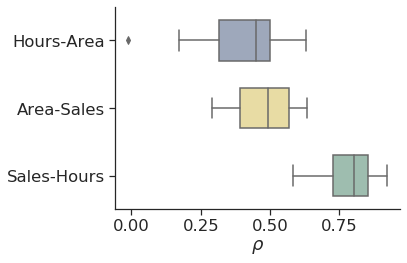

In [31]:
sns.set_context("notebook", font_scale = 1.5)
fig_boxplot = sns.boxplot(data = cor,
                          x = 'PCC', y = 'Relation',
                          width = 0.6,
                          palette = ['#99a7c0', '#f3e399', '#99c2b0'],
                          orient = 'h')
fig_boxplot.set_ylabel('')
sns.despine()
plt.xlabel(r"$\rho$") 
fig_boxplot.figure.tight_layout()
fig_boxplot.figure.savefig('out/box_pcc.png')
fig_boxplot.figure.savefig('docs/img/box_pcc.png')

It can be seen that the correlation between goods sold and working hours ratio stands out.

### Linear regression of hours ratio vs. sales units<a class="anchor" id="linearregression"></a>

First, we consider the dependence of the sales units on the invested working time. As we have seen before, this only makes sense if it is done per department. This leads us to a regression analysis of the goods sold depending on the hours worked.

We investigate this relation separated by departments and check whether we get a long dot cloud here, which would support a linear dependency.

/home/dennis/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/home/dennis/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dennis/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/dennis/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/dennis/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 

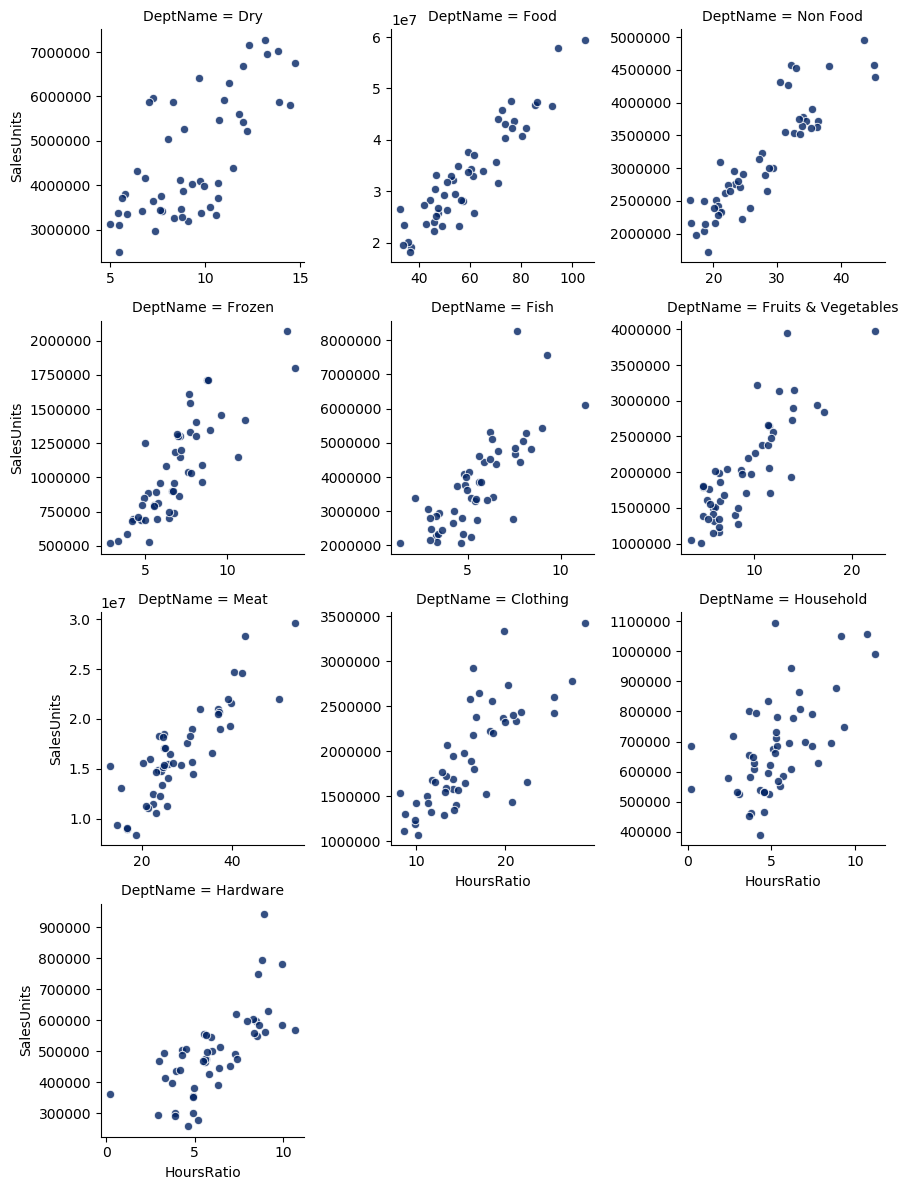

In [32]:
sns.reset_orig()
g = sns.FacetGrid(df,
                  col = 'DeptName',
                  col_wrap = 3,
                  sharex = False, sharey = False);
g.map(sns.scatterplot, 'HoursRatio', 'SalesUnits', alpha = .8, color = '#012363')
g.add_legend()
g.savefig('out/scatter_saleshours.png')

It can be seen that some of the departments such as *Frozen*, *Meat* or even general *Food* have a clearly defined linear structure. Others are a bit more indifferent, such as departments *Dry* and *Household*.

In the following, a linear line can be plotted for a selected department.

In [33]:
def plot_lm(deptname):
    ax = sns.lmplot(data = df[df['DeptName'] == deptname],
                    x = 'HoursRatio',
                    y = 'SalesUnits')

@interact
def show_plot_lm(DeptName = final_dept_list):
    return plot_lm(DeptName)

interactive(children=(Dropdown(description='DeptName', options=('Clothing', 'Dry', 'Fish', 'Food', 'Frozen', '…

### Predictive model<a class="anchor" id="predictivemodel"></a>

For the remaining departments in the dataset a linear regression is modeled as a predictive algorithm in the following.

The model uses the linear regression model of the scikit-learn library (see https://bit.ly/2ZzR3UY). The ratio of the test set is 25% and R^2 is used as evaluation score (see https://bit.ly/30N9Vxc).

In [34]:
@interact
def plot_model(deptname = final_dept_list):
    # Creating training and test set
    X_all = df[df['DeptName'] == deptname][['HoursRatio']].values
    y_all = df[df['DeptName'] == deptname][['SalesUnits']].values/1000000          # for smaller axis tick labels
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all,
                                                                        test_size = 0.25,
                                                                        random_state = 42)
    
    # Initiating and fitting model
    lrm = LinearRegression()
    lrm.fit(X_train_all, y_train_all)
    
    # Parameters
    a = lrm.coef_[0]
    b = lrm.intercept_
    r2_training = lrm.score(X_train_all, y_train_all)
    r2_test = lrm.score(X_test_all, y_test_all)
    
    # Printing function
    print('Function: f(w) = %.3f * w + %.3f' % (a, b))
    print("Intercept: {}".format(a))
    print("Slope: {}".format(b))
    print('Training set R² score: {:.2f}'.format(r2_training))
    print('Test set R² score: {:.2f}'.format(r2_test))
    
    # Plotting
    df_concat_train = pd.DataFrame(np.hstack((X_train_all, y_train_all)))
    df_concat_train['Set'] = 'Train'
    df_concat_test = pd.DataFrame(np.hstack((X_test_all, y_test_all)))
    df_concat_test['Set'] = 'Test'
    df_concat_pred = pd.DataFrame(np.hstack((X_train_all, lrm.predict(X_train_all))))
    
    df_concat = pd.concat([df_concat_train, df_concat_test])
    
    df_concat.columns = ['X', 'y', 'Set']
    df_concat_pred.columns = ['X', 'y']
    
    ax = sns.scatterplot(data = df_concat,
                     x = 'X',
                     y = 'y',
                     hue = 'Set',
                     palette = ['#012363', '#e3b900'])
    
    sns.lineplot(data = df_concat_pred,
             x = 'X',
             y = 'y',
             color = '#dd3e21',
             ax = ax)
    
    sns.despine()
    plt.xlabel(r'Ratio of working hours $w$')
    plt.ylabel(r'Sales units $s$ [1e6]')
    
    filename = 'out/prediction_' + deptname + '.png'
    ax.figure.savefig(filename)
    
    return ax

interactive(children=(Dropdown(description='deptname', options=('Clothing', 'Dry', 'Fish', 'Food', 'Frozen', '…